In [1]:
import pandas as pd

df_2_usual_explorerer = pd.read_parquet("df_15emergencyDays")


In [5]:
import numpy as np
import pandas as pd

def compute_radius_of_gyration(df):
    """
    Compute the radius of gyration for each user in the provided DataFrame chunk.
    
    Parameters:
    df (DataFrame): DataFrame containing columns 'uid', 'x', 'y', and 'time_spent'.
    
    Returns:
    DataFrame: A DataFrame with 'uid' and their corresponding 'radius_of_gyration'.
    """
    results = []

    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values

        total_time = np.sum(t)
        x_c = np.sum(x * t) / total_time
        y_c = np.sum(y * t) / total_time

        squared_distances = (x - x_c)**2 + (y - y_c)**2
        r_g_grid = np.sqrt(np.sum(t * squared_distances) / total_time)
        r_g_meters = r_g_grid * 500  # Convert grid units to meters

        results.append({'uid': uid, 'radius_of_gyration': r_g_meters})

    return pd.DataFrame(results)


In [6]:
chunk_size = 100000  # Adjust based on your system's memory capacity
aggregated_results = []

# Assuming 'df_15mcity_collapsed' is your large DataFrame
for start in range(0, len(df_2_usual_explorerer), chunk_size):
    end = start + chunk_size
    chunk = df_2_usual_explorerer.iloc[start:end]
    chunk_results = compute_radius_of_gyration(chunk)
    aggregated_results.append(chunk_results)

# Combine all chunk results
df_2_usual_results = pd.concat(aggregated_results).groupby('uid', as_index=False).mean()

print(df_2_usual_results.head())


   uid  radius_of_gyration
0    0        21885.976856
1    1         4631.713671
2    2        11633.634713
3    3        17654.142491
4    4         5051.910073


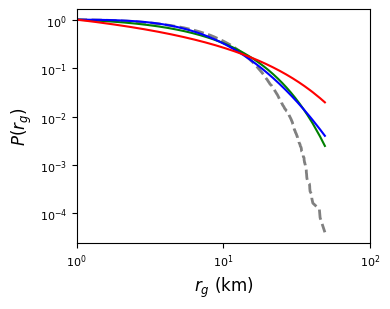

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from matplotlib.ticker import NullLocator, LogFormatterMathtext

# === Load and fit full radius of gyration in kilometers ===
rg_m = df_2_usual_results['radius_of_gyration'].dropna().values
rg_km = rg_m / 1000.0
fit_rg = powerlaw.Fit(rg_km, xmin=1.0, discrete=False)

# === Plot ===
fig = plt.figure(figsize=(4, 3.2), dpi=100)
ax = fig.add_subplot(111)

# Empirical CCDF (dashed)
fit_rg.plot_ccdf(ax=ax, color='gray', linestyle='--', linewidth=2, label='Empirical data')

# Fitted Curves (solid)
fit_rg.exponential.plot_ccdf(ax=ax, color='green', linestyle='-', label='Exponential Fit')
fit_rg.lognormal.plot_ccdf(ax=ax, color='blue', linestyle='-', label='Lognormal Fit')
fit_rg.truncated_power_law.plot_ccdf(ax=ax, color='red', linestyle='-', label='Truncated Power Law Fit')

# Adjust axes
ax.set_xscale('log')
ax.set_xlim(1e0, 1e2)
ax.set_xticks([1e0, 1e1, 1e2])
ax.get_xaxis().set_major_formatter(LogFormatterMathtext(base=10))
ax.get_xaxis().set_minor_locator(NullLocator())
ax.get_yaxis().set_minor_locator(NullLocator())

# Labels and styling
ax.set_xlabel(r'$r_g\ (\mathrm{km})$', fontsize=12)
ax.set_ylabel(r'$P(r_g)$', fontsize=12)
#ax.set_title('Emergency period', fontsize=12)
#ax.legend(frameon=False, fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(False)

plt.tight_layout()
plt.show()


In [44]:
import powerlaw
import pandas as pd

# === Step 1: Prepare radius of gyration in kilometers ===
rg_m = df_2_usual_results['radius_of_gyration'].dropna().values
rg_km = rg_m / 1000.0

# === Step 2: Fit data using powerlaw package with fixed xmin ===
fit = powerlaw.Fit(rg_km, xmin=1.0, discrete=False)

# === Step 3: Extract lognormal parameters ===
mu = fit.lognormal.mu
sigma = fit.lognormal.sigma
xmin = fit.lognormal.xmin

# === Step 4: Compare lognormal against truncated power law and exponential ===
R_vs_tpl, p_vs_tpl = fit.distribution_compare('lognormal', 'truncated_power_law')
R_vs_exp, p_vs_exp = fit.distribution_compare('lognormal', 'exponential')

# === Step 5: Format results in a DataFrame ===
result = pd.DataFrame([{
    "Lognormal parameters (μ, σ)": f"{mu:.4f}, {sigma:.4f}",
    "X_min": f"{xmin:.4f}",
    "Lognormal vs Truncated Power Law (R)": f"{R_vs_tpl:.4f}",
    "p-value vs Truncated Power Law": f"{p_vs_tpl:.4f}",
    "Lognormal vs Exponential (R)": f"{R_vs_exp:.4f}",
    "p-value vs Exponential": f"{p_vs_exp:.4f}"
}])

# === Step 6: Display ===
print(result.to_string(index=False))

# Optional: save to CSV
# result.to_csv("fit_summary_lognormal_vs_tpl.csv", index=False)


Lognormal parameters (μ, σ)  X_min Lognormal vs Truncated Power Law (R) p-value vs Truncated Power Law Lognormal vs Exponential (R) p-value vs Exponential
             1.9639, 0.7295 1.0000                            6428.1967                         0.0000                     720.1333                 0.0000


In [47]:
import numpy as np
import pandas as pd
import powerlaw

# === Function to compute radius of gyration ===
def compute_radius_of_gyration(df):
    results = []
    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values
        if t.sum() == 0:
            continue
        x_c = np.sum(x * t) / np.sum(t)
        y_c = np.sum(y * t) / np.sum(t)
        squared_distances = (x - x_c)**2 + (y - y_c)**2
        r_g_grid = np.sqrt(np.sum(t * squared_distances) / np.sum(t))
        r_g_meters = r_g_grid * 500
        results.append({'uid': uid, 'radius_of_gyration': r_g_meters})
    return pd.DataFrame(results)

# === Storage for results ===
results_list = []

# === Loop over days 11 to 25 ===
for day in range(60, 75):
    df_day = df_2_usual_explorerer[df_2_usual_explorerer['d'] == day]
    rg_df = compute_radius_of_gyration(df_day)

    # Convert to km and fit distribution
    rg_km = rg_df['radius_of_gyration'].dropna().values / 1000.0
    if len(rg_km) < 10:
        continue  # skip days with insufficient data

    fit = powerlaw.Fit(rg_km, discrete=False, verbose=False)

    # Compare lognormal to others
    R_log_vs_exp, _ = fit.distribution_compare('lognormal', 'exponential')
    R_log_vs_pwr, _ = fit.distribution_compare('lognormal', 'truncated_power_law')

    mu = fit.lognormal.mu
    sigma = fit.lognormal.sigma
    xmin = fit.lognormal.xmin

    results_list.append({
        'day': day,
        'mu': mu,
        'sigma': sigma,
        'xmin': xmin,
        'lognormal_vs_exponential': R_log_vs_exp,
        'lognormal_vs_truncated_power_law': R_log_vs_pwr
    })

# === Convert to DataFrame and show results ===
results_df = pd.DataFrame(results_list)
print(results_df)


    day        mu     sigma       xmin  lognormal_vs_exponential  \
0    60  2.661092  0.411553  15.692641                 -0.695135   
1    61  3.147584  0.238615  29.200680                  0.606195   
2    62  2.942983  0.312273  20.233664                  4.975631   
3    63  3.293365  0.194427  32.093578                  0.631050   
4    64  2.928823  0.324470  19.684030                  5.151272   
5    65  3.114654  0.245495  30.955813                  0.144745   
6    66  2.935138  0.287566  31.924132                 -0.025005   
7    67  3.028126  0.294134  23.457944                  2.137878   
8    68  2.805710  0.362286  19.889616                  0.044318   
9    69  2.930637  0.278401  31.310288                  0.007920   
10   70  1.307358  0.455698  36.174361                  0.054931   
11   71  2.635747  0.425054  15.093773                 -2.247830   
12   72  2.560791  0.344935  32.802731                 -0.060001   
13   73  3.262254  0.218471  30.668862          

In [51]:
import numpy as np
import pandas as pd
import powerlaw

# === Function to compute full radius of gyration ===
def compute_r_g(df):
    results = []
    for uid, group in df.groupby('uid'):
        x = group['x'].values
        y = group['y'].values
        t = group['time_spent'].values
        if t.sum() == 0:
            continue
        x_c = np.sum(x * t) / np.sum(t)
        y_c = np.sum(y * t) / np.sum(t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        r_g = np.sqrt(np.sum(t * dist_sq) / np.sum(t)) * 500
        results.append(r_g)
    return np.array(results)

# === Function to compute top-k radius of gyration ===
def compute_r_k(df, k):
    rk_list = []
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_list.append(rk)
    return np.array(rk_list)

# === Analyze and fit lognormal for r_g and r_k ===
k_values = [1, 2, 3, 4, 5, 8]
fit_results = []

for k in k_values:
    if k == 1:
        data = compute_r_g(df_2_usual_explorerer)
        label = "r_g"
    else:
        data = compute_r_k(df_2_usual_explorerer, k)
        label = f"r_{k}"

    data_km = data / 1000.0
    fit = powerlaw.Fit(data_km, xmin=1.0, discrete=False,verbose=False)

    fit_results.append({
        'metric': label,
        'mu': fit.lognormal.mu,
        'sigma': fit.lognormal.sigma,
        'xmin': 1,
        'n': len(data_km)
    })

# === Convert to DataFrame and display ===
fit_df = pd.DataFrame(fit_results)
print(fit_df)


  metric        mu     sigma  xmin      n
0    r_g  1.964023  0.729458     1  25000
1    r_2  1.345017  0.889797     1  25000
2    r_3  1.372340  0.894471     1  25000
3    r_4  1.425128  0.885098     1  25000
4    r_5  1.474336  0.879009     1  25000
5    r_8  1.617846  0.842132     1  25000


 The followning code generates the plot for k=2. You can the value of k (k=2) to produce plost for other values.

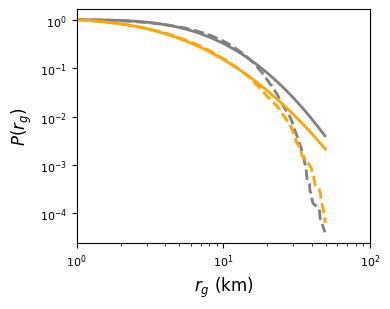

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from matplotlib.ticker import NullLocator

# === Define k ===
k = 2  # Set k once at the beginning

# === Load and prepare full radius of gyration (in km) ===
rg_m = df_2_usual_results['radius_of_gyration'].dropna().values
rg_km = rg_m / 1000.0
fit_rg = powerlaw.Fit(rg_km, xmin=1.0, discrete=False, verbose=False)

# === Compute r_k for the defined k ===
def compute_rk(df, k):
    rk_list = []
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500 / 1000.0  # Convert to km
        rk_list.append(rk)
    return np.array(rk_list)

# === Fit r_k with the defined k ===
r2g_km = compute_rk(df_2_usual_explorerer, k)
fit_r2g = powerlaw.Fit(r2g_km, xmin=1.0, discrete=False, verbose=False)

# === Plot ===
fig = plt.figure(figsize=(4, 3.2), dpi=100)
ax = fig.add_subplot(111)

# Plot empirical CCDFs (dashed)
fit_rg.plot_ccdf(ax=ax, color='gray', linestyle='--', linewidth=2)    
fit_r2g.plot_ccdf(ax=ax, color='orange', linestyle='--', linewidth=2)  

# Plot lognormal fits (solid)
fit_rg.lognormal.plot_ccdf(ax=ax, color='gray', linestyle='-', linewidth=2)
fit_r2g.lognormal.plot_ccdf(ax=ax, color='orange', linestyle='-', linewidth=2)

# Turn off y-minor ticks
ax.yaxis.set_minor_locator(NullLocator())

# Axis formatting
ax.set_xscale('log')
ax.set_xlim(1e0, 1e2)
ax.set_xticks([1e0, 1e1, 1e2])
ax.set_xlabel(r'$r_g\ (\mathrm{km})$', fontsize=12)
ax.set_ylabel(r'$P(r_g)$', fontsize=12)
#ax.set_title(f'k={k}', fontsize=12)  # Optional: Display k value in title
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(False)

# No legend
plt.tight_layout()
plt.show()


 The followning code generates the scatter plot for k=2. You can the value of k (k=2) to produce plost for other values.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

k = 2  # Top-k locations

# === Step 1: Compute rₖg ===
def compute_rk_all(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c) ** 2 + (y - y_c) ** 2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Step 2: Match with full rg ===
rk_dict = compute_rk_all(df_2_usual_explorerer, k=k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

common_uids = set(rg_dict).intersection(rk_dict)
rg_vals = np.array([rg_dict[uid] for uid in common_uids])
rk_vals = np.array([rk_dict[uid] for uid in common_uids])

# === Step 3: Compute density for color ===
xy = np.vstack([rg_vals, rk_vals])
z = gaussian_kde(xy)(xy)

# === Step 4: Plot ===
fig = plt.figure(figsize=(4, 3.2), dpi=100)
sc = plt.scatter(rg_vals, rk_vals, c=z, s=10, cmap='plasma', alpha=0.7)

# 45° Line (no label, no legend entry)
plt.plot([0, 60000], [0, 60000], 'k--', linewidth=1.5)

# Axes settings
plt.xlim(0, 60000)
plt.ylim(0, 60000)
tick_vals = np.arange(0, 60001, 10000)
tick_labels = [f"{x // 1000}" for x in tick_vals]
plt.xticks(tick_vals, labels=tick_labels)
plt.yticks(tick_vals, labels=tick_labels)

plt.xlabel(r"$r_g$ (km)", fontsize=12)
plt.ylabel(r"$r_g^{(2)}$ (km)", fontsize=12)
#plt.title(f'k={k}', fontsize=12)
plt.colorbar(sc, label='Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.grid(False)  # Turn off grid lines

plt.tight_layout()
plt.show()


 The followning code generates the plot for k=2. You can the value of k (k=2) to produce plost for other values.

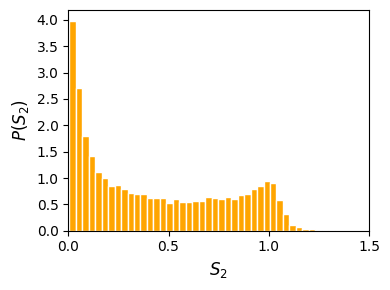

In [10]:
import numpy as np
import matplotlib.pyplot as plt

k = 2  # Top-k time-weighted locations

# === Step 1: Compute rₖg from time-based locations ===
def compute_rk_dict(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c) ** 2 + (y - y_c) ** 2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Step 2: Load r_g from full mobility ===
rk_dict = compute_rk_dict(df_2_usual_explorerer, k=k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# === Step 3: Compute Sₖ = rₖ / r_g ===
common_uids = set(rk_dict).intersection(rg_dict)
sk_vals = np.array([rk_dict[uid] / rg_dict[uid] for uid in common_uids if rg_dict[uid] > 0])

# === Step 4: Plot distribution of Sₖ ===
fig = plt.figure(figsize=(4, 3), dpi=100)
n, bins, patches = plt.hist(sk_vals, bins=50, density=True, color='orange', edgecolor='white')

plt.xlim(0, 1.5)
plt.xticks(np.arange(0, 1.51, 0.5))
plt.yticks(np.arange(0, max(n)+0.1, 0.5))  # Clean y-axis ticks

plt.xlabel(f"$S_{k}$", fontsize=12)
plt.ylabel(f"$P(S_{k})$", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


The following code generates a plot showing the percentage of explorers and returners across different values of 
k for the first 7 days of the emergency period. You can modify the code to produce similar plots for other durations or time periods.

In [48]:
df_2_usual_explorerer = pd.read_parquet("/work/wissamkontar/omida/YJMob100K/Code/df_15emergencyDays")


In [38]:
df_2_usual_explorerer = df_2_usual_explorerer[df_2_usual_explorerer['d'].isin([67,68,69,70,71,72,73])]

In [39]:
chunk_size = 100000  # Adjust based on your system's memory capacity
aggregated_results = []

# Assuming 'df_15mcity_collapsed' is your large DataFrame
for start in range(0, len(df_2_usual_explorerer), chunk_size):
    end = start + chunk_size
    chunk = df_2_usual_explorerer.iloc[start:end]
    chunk_results = compute_radius_of_gyration(chunk)
    aggregated_results.append(chunk_results)

# Combine all chunk results
df_2_usual_results = pd.concat(aggregated_results).groupby('uid', as_index=False).mean()

print(df_2_usual_results.head())


/tmp/ipykernel_1375887/187238891.py:22: RuntimeWarning: invalid value encountered in scalar divide
  x_c = np.sum(x * t) / total_time
/tmp/ipykernel_1375887/187238891.py:23: RuntimeWarning: invalid value encountered in scalar divide
  y_c = np.sum(y * t) / total_time


   uid  radius_of_gyration
0    0         6984.317249
1    1         4352.022192
2    2        11567.057294
3    3        17272.562428
4    4         4941.829428


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Function to compute radius of gyration ===
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# === Function to classify returner vs explorer ===
def classify_users(df, rg_dict, k):
    rk_dict = compute_rk(df, k)
    common_uids = set(rg_dict).intersection(rk_dict)
    result = {'returner': 0, 'explorer': 0}
    
    for uid in common_uids:
        rg = rg_dict[uid]
        rk = rk_dict[uid]
        if rg == 0:
            continue
        sk = rk / rg
        if sk > 0.5:
            result['returner'] += 1
        else:
            result['explorer'] += 1
    total = result['returner'] + result['explorer']
    result['returner_pct'] = 100 * result['returner'] / total
    result['explorer_pct'] = 100 * result['explorer'] / total
    return result

# === Load rg from results ===
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# === Classify users for multiple k values ===
k_values = [2, 3, 4, 5, 6, 8, 10]
explorer_pcts = []
returner_pcts = []

for k in k_values:
    stats = classify_users(df_2_usual_explorerer, rg_dict, k)
    explorer_pcts.append(stats['explorer_pct'])
    returner_pcts.append(stats['returner_pct'])



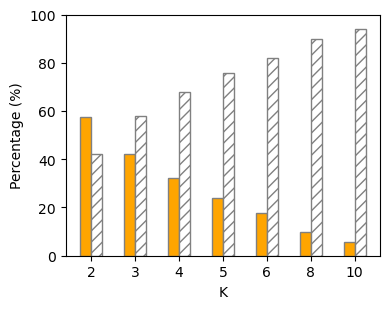

In [41]:
# === Plot ===
x = np.arange(len(k_values))
width = 0.25  # Narrower bars

plt.figure(figsize=(4, 3.2), dpi=100)
plt.bar(x - width/2, explorer_pcts, width, label='Explorers',
        color='orange', edgecolor='gray')
plt.bar(x + width/2, returner_pcts, width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

plt.xticks(x, k_values)
plt.xlabel("K")
plt.ylabel("Percentage (%)")
#plt.title("Emergency period")
#plt.legend()
plt.ylim(0, 100)  # Set y-axis limit to be from 0% to 100%
plt.grid(False)
plt.tight_layout()

plt.show()


The following code generates a plot of the maximum distance from home.

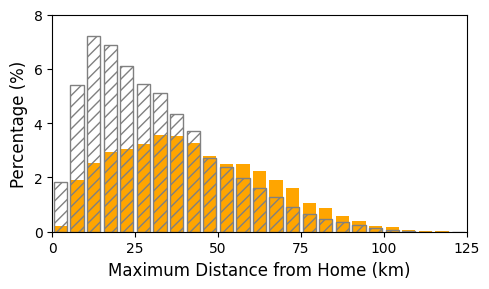

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k = 4  # Top-k time-weighted locations

# --- Step 1: Max distance from home ---
df = df_2_usual_explorerer.copy()
df['dist_from_home'] = np.sqrt((df['x'] - df['x_h'])**2 + (df['y'] - df['y_h'])**2) * 0.5  # km
max_dist = df.groupby('uid')['dist_from_home'].max().reset_index(name='max_dist')

# --- Step 2: Classify users ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

rk_dict = compute_rk(df, k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification = {}
for uid in max_dist['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

max_dist['class'] = max_dist['uid'].map(classification)
max_dist = max_dist.dropna()

# --- Step 3: Binning ---
bin_width = 5
bins = np.arange(0, 130, bin_width)
bin_centers = bins[:-1] + bin_width / 2
max_dist['bin'] = pd.cut(max_dist['max_dist'], bins=bins, labels=bin_centers, right=False)

# --- Step 4: Aggregate ---
group_counts = max_dist.groupby(['bin', 'class']).size().unstack(fill_value=0)
group_counts['total'] = group_counts.sum(axis=1)
total_users = len(max_dist)
group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100

# --- Step 5: Plot ---
x = np.array(group_counts.index, dtype=float)
width = bin_width * 0.8  # slight space between bars

plt.figure(figsize=(5, 3), dpi=100)
plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

plt.xticks(np.arange(0, 151, 25))  # Ticks up to 150
plt.xlim(0, 125)  # Ensure plot extends to 150 km
plt.ylim(0, 8)
plt.xlabel("Maximum Distance from Home (km)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
#plt.title("Emergency period", fontsize=12)
#plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()



The following code calculates and plots the maximum distance from home for each individual day in the dataset.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Define a function to calculate and classify ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# --- Step 2: Classify users once using full dataset ---
# Use df_2_usual_explorerer or whatever your full dataset is called
rk_dict = compute_rk(df_2_usual_explorerer, k=4)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification = {}
for uid in df_2_usual_explorerer['uid'].unique():
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

# --- Step 3: Loop over the days and generate plots ---
for day in range(60, 75):  # Loop from 60 to 74
    # Filter df_2_usual_explorerer based on the current day
    filtered_df = df_2_usual_explorerer[df_2_usual_explorerer['d'] == day]
    
    # --- Step 4: Max distance from home ---
    df = filtered_df.copy()
    df['dist_from_home'] = np.sqrt((df['x'] - df['x_h'])**2 + (df['y'] - df['y_h'])**2) * 0.5  # km
    max_dist = df.groupby('uid')['dist_from_home'].max().reset_index(name='max_dist')

    # --- Step 5: Assign precomputed class labels ---
    max_dist['class'] = max_dist['uid'].map(classification)
    max_dist = max_dist.dropna()

    # --- Step 6: Binning ---
    bin_width = 5
    bins = np.arange(0, 130, bin_width)
    bin_centers = bins[:-1] + bin_width / 2
    max_dist['bin'] = pd.cut(max_dist['max_dist'], bins=bins, labels=bin_centers, right=False)

    # --- Step 7: Aggregate ---
    group_counts = max_dist.groupby(['bin', 'class']).size().unstack(fill_value=0)
    group_counts['total'] = group_counts.sum(axis=1)
    total_users = len(max_dist)
    group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
    group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100

    # --- Step 8: Plot ---
    x = np.array(group_counts.index, dtype=float)
    width = bin_width * 0.8  # slight space between bars

    plt.figure(figsize=(5, 3), dpi=100)
    plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
    plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

    plt.xticks(np.arange(0, 151, 25))
    plt.xlim(0, 125)
    plt.ylim(0, 35)
    plt.xlabel("Maximum Distance from Home (km)", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.grid(False)
    plt.tight_layout()

    # Save the plot with appropriate filename
    plt.savefig(f"emergency_day{day - 59}.png", dpi=300, bbox_inches="tight")
    plt.close()


The following code generates the Mann-Whitney U test results comparing the maximum distance from home distributions.

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming 'max_dist' DataFrame contains 'class' and 'max_dist' columns

# Separate the data for returners and explorers
returners = max_dist[max_dist['class'] == 'returner']['max_dist']
explorers = max_dist[max_dist['class'] == 'explorer']['max_dist']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 52887620.0
P-value: 0.0
Significance: **


The following code generates the Kolmogorov-Smirnov test results comparing the maximum distance from home distributions.

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming 'max_dist' DataFrame contains 'class' and 'max_dist' columns

# Separate the data for returners and explorers
returners = max_dist[max_dist['class'] == 'returner']['max_dist']
explorers = max_dist[max_dist['class'] == 'explorer']['max_dist']

# Perform Mann-Whitney U test
stat, p_value = ks_2samp(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 0.22477929218281645
P-value: 3.8095970544737176e-269
Significance: **


The following code generates a plot of the non-home dwelling time.

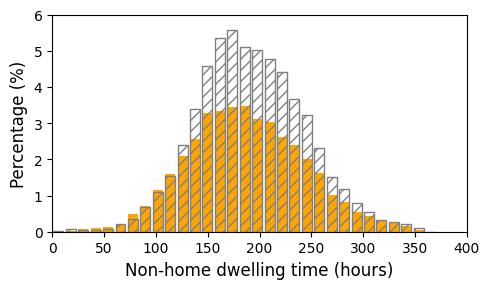

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k = 4  # Top-k time-weighted locations

# --- Step 1: Sum time spent away from home ---
df = df_2_usual_explorerer.copy()
df['time_away_from_home'] = np.where((df['x'] != df['x_h']) | (df['y'] != df['y_h']), df['time_spent'], 0)
time_away = df.groupby('uid')['time_away_from_home'].sum().reset_index(name='time_away_from_home')

# --- Step 2: Classify users ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

rk_dict = compute_rk(df, k)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification = {}
for uid in time_away['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

time_away['class'] = time_away['uid'].map(classification)
time_away = time_away.dropna()

# --- Step 3: Automatically create bins based on the data ---
# Use pandas to create bins based on the data distribution
bin_width = time_away['time_away_from_home'].max() / 30  # Approximate bin width to cover the range
bins = np.arange(0, time_away['time_away_from_home'].max() + bin_width, bin_width)
bin_centers = bins[:-1] + bin_width / 2
time_away['bin'] = pd.cut(time_away['time_away_from_home'], bins=bins, labels=bin_centers, right=False)

# --- Step 4: Aggregate ---
group_counts = time_away.groupby(['bin', 'class']).size().unstack(fill_value=0)
group_counts['total'] = group_counts.sum(axis=1)
total_users = len(time_away)
group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100

# --- Step 5: Plot ---
x = np.array(group_counts.index, dtype=float)
width = bin_width * 0.8  # slight space between bars

plt.figure(figsize=(5, 3), dpi=100)
plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

plt.xlabel("Non-home dwelling time (hours)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
#plt.title("Distribution by Time Spent Away from Home (k=4)", fontsize=12)
#plt.legend()
plt.xlim(0, 400)  # Ensure plot extends to 150 km
plt.ylim(0, 6)
plt.grid(False)
plt.tight_layout()
plt.show()


The following code generates the Mann-Whitney U test results comparing the non-home dwelling time distributions.

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming you already have the 'time_away' DataFrame with 'class' and 'time_away_from_home'

# Separate the data for returners and explorers
returners = time_away[time_away['class'] == 'returner']['time_away_from_home']
explorers = time_away[time_away['class'] == 'explorer']['time_away_from_home']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 79830277.0
P-value: 1.0539647323644939e-13
Significance: **


The following code generates the Kolmogorov-Smirnov test results comparing the non-home dwelling time distributions.

In [10]:
from scipy.stats import ks_2samp
import numpy as np
import pandas as pd

# Assuming you already have the 'time_away' DataFrame with 'class' and 'time_away_from_home'

# Separate the data for returners and explorers
returners = time_away[time_away['class'] == 'returner']['time_away_from_home']
explorers = time_away[time_away['class'] == 'explorer']['time_away_from_home']

# Perform Mann-Whitney U test
stat, p_value = ks_2samp(returners, explorers)

# Print results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")

Statistic: 0.05935247372071492
P-value: 5.611239734707968e-19
Significance: **


The following code calculates and plots the non-home dwelling time for each individual day in the dataset.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Define a function to calculate rk ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

# --- Step 2: Pre-compute classification using the full dataset ---
rk_dict_full = compute_rk(df_2_usual_explorerer, k=4)
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

classification_full = {}
for uid in df_2_usual_explorerer['uid'].unique():
    if uid in rk_dict_full and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict_full[uid] / rg_dict[uid]
        classification_full[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification_full[uid] = np.nan

# --- Step 3: Loop over the days and generate plots ---
for day in range(60, 75):
    filtered_df = df_2_usual_explorerer[df_2_usual_explorerer['d'] == day].copy()
    
    # Time spent away from home
    filtered_df['time_away_from_home'] = np.where(
        (filtered_df['x'] != filtered_df['x_h']) | (filtered_df['y'] != filtered_df['y_h']),
        filtered_df['time_spent'],
        0
    )
    time_away = filtered_df.groupby('uid')['time_away_from_home'].sum().reset_index(name='time_away_from_home')
    
    # Map classification
    time_away['class'] = time_away['uid'].map(classification_full)
    time_away = time_away.dropna()
    
    # Binning
    bin_width = 1
    bins = np.arange(0, 25, bin_width)
    bin_centers = bins[:-1] + bin_width / 2
    time_away['bin'] = pd.cut(time_away['time_away_from_home'], bins=bins, labels=bin_centers, right=False)
    
    # Aggregation
    group_counts = time_away.groupby(['bin', 'class']).size().unstack(fill_value=0)
    group_counts['total'] = group_counts.sum(axis=1)
    total_users = len(time_away)
    group_counts['explorer_pct'] = (group_counts.get('explorer', 0) / total_users) * 100
    group_counts['returner_pct'] = (group_counts.get('returner', 0) / total_users) * 100

    # Plotting
    x = np.array(group_counts.index, dtype=float)
    width = bin_width * 0.8

    plt.figure(figsize=(5, 3), dpi=100)
    plt.bar(x, group_counts['explorer_pct'], width=width, color='orange', label='Explorer')
    plt.bar(x, group_counts['returner_pct'], width=width, facecolor='none', edgecolor='gray', hatch='///', label='Returner')

    plt.xlim(0, 24)
    plt.ylim(0, 8)
    plt.xlabel("Non-home dwelling time (hours)", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"emergency_day{day - 59}.png", dpi=300, bbox_inches="tight")
    plt.close()


The following code generates the plot for 4 groups. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define group colors and labels
group_styles = {
    1: {'label': 'Returner-Returner', 'color': 'blue'},
    2: {'label': 'Returner-Explorer', 'color': 'green'},
    3: {'label': 'Explorer-Explorer', 'color': 'orange'},
    4: {'label': 'Explorer-Returner', 'color': 'red'}
}

# Main analysis loop
for day in range(60, 75):  # Days 60 to 74
    plt.figure(figsize=(5, 3), dpi=100)
    
    # Filter for current day and all reclass groups
    filtered_df = df_2_usual_explorerer[
        (df_2_usual_explorerer['d'] == day) & 
        (df_2_usual_explorerer['reclass'].isin([1, 2, 3, 4]))
    ]
    
    # Calculate max distance from home (in km)
    df = filtered_df.copy()
    df['dist_from_home'] = np.sqrt((df['x'] - df['x_h'])**2 + (df['y'] - df['y_h'])**2) * 0.5
    max_dist = df.groupby('uid')['dist_from_home'].max().reset_index(name='max_dist')
    max_dist = pd.merge(max_dist, df[['uid', 'reclass']].drop_duplicates(), on='uid')
    
    # Binning (5-km bins up to 125 km)
    bin_width = 5
    bins = np.arange(0, 130, bin_width)
    bin_centers = bins[:-1] + bin_width / 2
    
    # Plot each group's distribution
    for reclass in [1, 2, 3, 4]:
        group_data = max_dist[max_dist['reclass'] == reclass]
        hist_values, _ = np.histogram(group_data['max_dist'], bins=bins)
        pct_values = (hist_values / len(max_dist)) * 100  # % of total population
        
        plt.plot(bin_centers, pct_values, 
                color=group_styles[reclass]['color'],
                marker='o',
                linestyle='-',
                linewidth=1.5,
                markersize=3,
                label=group_styles[reclass]['label'])
    
    # Match reference distance plot styling
    plt.xlim(0, 125)
    plt.ylim(0, 15)
    plt.xlabel("Maximum Distance from Home (km)", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.grid(False)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    # Only show legend on first plot
    if day == 60:
        plt.legend(loc='upper right', fontsize=10, framealpha=1)
    
    plt.tight_layout()
    plt.savefig(f"maxDist_lines_day{day - 59}.png", dpi=300, bbox_inches="tight")
    plt.close()

# Entropy

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter  # Import Counter


# Example data: Assuming df_2_usual_explorerer contains 'uid', 'x', 'y', 'time_spent', and 'class' columns.
# Replace this with your actual data loading
# df_2_usual_explorerer = ...

# === Step 1: Calculate real entropy for each user ===
def calculate_real_entropy(group, window_size=2):
    """
    Calculate real entropy for each user based on time-ordered subsequences of visited locations.
    
    Parameters:
    group (DataFrame): User's trajectory data with columns ['x', 'y', 'time_spent']
    window_size (int): Size of the subsequence to consider
    
    Returns:
    float: Real entropy for the user
    """
    trajectory = list(zip(group['x'], group['y']))  # Create the sequence of visited locations
    
    # Generate subsequences of the given window size
    subsequences = [tuple(trajectory[i:i+window_size]) for i in range(len(trajectory) - window_size + 1)]
    
    # Calculate the frequency of each subsequence
    subseq_counts = Counter(subsequences)
    
    # Calculate the probabilities of each subsequence
    total_subsequences = sum(subseq_counts.values())
    probabilities = np.array([count / total_subsequences for count in subseq_counts.values()])
    
    # Calculate entropy: -sum(P * log2(P))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

# === Step 2: Compute r_k for users ===
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500  # Convert to meters
        rk_dict[uid] = rk
    return rk_dict

# === Step 3: Classify users into returners and explorers based on r_k and radius_of_gyration ===
# Assuming 'radius_of_gyration' is already computed in 'df_2_usual_results' (e.g., from previous steps)

# --- Compute r_k for users ---
k = 4  # Top-k time-weighted locations
rk_dict = compute_rk(df_2_usual_explorerer, k)

# Assuming 'df_2_usual_results' has the radius of gyration values
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# Classify users as 'returners' and 'explorers' based on the ratio of r_k to radius_of_gyration
classification = {}
for uid in df_2_usual_explorerer['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

df_2_usual_explorerer['class'] = df_2_usual_explorerer['uid'].map(classification)

# === Step 4: Calculate real entropy for each user ===
entropy_dict = df_2_usual_explorerer.groupby('uid').apply(calculate_real_entropy).to_dict()
df_2_usual_explorerer['real_entropy'] = df_2_usual_explorerer['uid'].map(entropy_dict)

# === Step 5: Separate returners and explorers ===
returners = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'returner']['real_entropy']
explorers = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'explorer']['real_entropy']




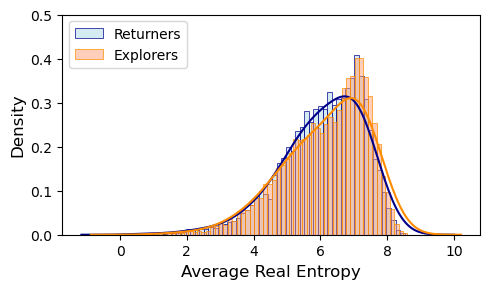

In [27]:
# === Step 6: Plotting the KDE for real entropy with bars and smoother curves ===
plt.figure(figsize=(5, 3))

# Plot bars for returners (light blue, transparent with darker border, narrow border)
sns.histplot(returners, kde=False, color='lightblue', label='Returners', bins=60, stat='density', alpha=0.5, edgecolor='darkblue', linewidth=0.5)

# Plot bars for explorers (light orange, transparent with darker border, narrow border)
sns.histplot(explorers, kde=False, color='lightsalmon', label='Explorers', bins=60, stat='density', alpha=0.5, edgecolor='darkorange', linewidth=0.5)

# KDE plot for returners (same color as bars, light blue, narrow and darker) with legend=False
sns.kdeplot(returners, color='darkblue', linewidth=1.5, bw_adjust=8, legend=False)

# KDE plot for explorers (same color as bars, light orange, narrow and darker) with legend=False
sns.kdeplot(explorers, color='darkorange', linewidth=1.5, bw_adjust=8, legend=False)

# Axis labels and title
plt.xlabel('Average Real Entropy', fontsize=12)
plt.ylabel('Density', fontsize=12)
#plt.title('Density Distribution of Average Real Entropy', fontsize=14)

# Set y-axis ticks to show every 0.1 interval, dynamically based on the range
plt.yticks(np.arange(0,0.6, 0.1))

# Add legend for bars only
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


The following code generates the Mann-Whitney U test results comparing the entropy distributions.

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming the 'real_entropy' column exists in df_2_usual_explorerer and 'class' is available
# Separate the data for returners and explorers based on the class column
returners = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'returner']['real_entropy']
explorers = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'explorer']['real_entropy']

# Perform Mann-Whitney U Test to check for significant difference in real entropy
stat, p_value = mannwhitneyu(returners, explorers)

# Print the results of the test
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at the 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at the 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")


Statistic: 3340296713739.0
P-value: 0.0
Significance: **


The following code generates the Kolmogorov-Smirnov test results comparing the entropy distributions.

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Separate the data for returners and explorers
returners = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'returner']['real_entropy']
explorers = df_2_usual_explorerer[df_2_usual_explorerer['class'] == 'explorer']['real_entropy']

# Perform Kolmogorov-Smirnov Test
stat, p_value = ks_2samp(returners, explorers)

# Print the results
print(f"KS Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of the p-value
if p_value < 0.01:
    significance = '**'  # Significant at the 0.01 level
elif p_value < 0.05:
    significance = '*'   # Significant at the 0.05 level
else:
    significance = 'NS'  # Not significant

print(f"Significance: {significance}")

KS Statistic: 0.05572434227750178
P-value: 0.0
Significance: **


# transitions

In [ ]:
import pandas as pd

# Assuming 'df_2_usual_explorerer' contains the user data and 'class' column has already been created
# If not, we can classify the users as 'returner' or 'explorer' using the following approach:

# --- Compute r_k for users ---
k = 4  # Top-k time-weighted locations
rk_dict = compute_rk(df_2_usual_explorerer, k)

# Assuming 'df_2_usual_results' has the radius of gyration values
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

# Classify users as 'returners' and 'explorers' based on the ratio of r_k to radius_of_gyration
classification = {}
for uid in df_2_usual_explorerer['uid']:
    if uid in rk_dict and uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict[uid] / rg_dict[uid]
        classification[uid] = 'returner' if sk > 0.5 else 'explorer'
    else:
        classification[uid] = np.nan

# Add classification as a new column
df_2_usual_explorerer['class'] = df_2_usual_explorerer['uid'].map(classification)

# Create a new DataFrame with UID, Returner, and Explorer columns
classification_df = pd.DataFrame({
    'UID': df_2_usual_explorerer['uid'],
    'Returner': df_2_usual_explorerer['class'].apply(lambda x: 1 if x == 'returner' else 0),
    'Explorer': df_2_usual_explorerer['class'].apply(lambda x: 1 if x == 'explorer' else 0)
})

# Save the DataFrame to a CSV file
classification_df.to_csv('user_classification_emerg.csv', index=False)


In [29]:
import pandas as pd
import numpy as np

# Load the classification data
df_emerg = pd.read_csv('user_classification_emerg.csv')  # Emergency classification data
df_usual = pd.read_csv('user_classification_usual.csv')  # Usual classification data

# Step 1: Remove duplicate rows for each UID
df_emerg_unique = df_emerg.drop_duplicates(subset=['UID'])
df_usual_unique = df_usual.drop_duplicates(subset=['UID'])

# Step 2: Merge usual and emergency classifications on UID
df_combined = pd.merge(
    df_usual_unique[['UID', 'Returner']], 
    df_emerg_unique[['UID', 'Returner']], 
    on='UID', 
    suffixes=('_usual', '_emerg')
)

# Step 3: Classify UIDs based on Returner status in both conditions
def classify_group(row):
    # Case 1: Returner in both usual and emergency
    if row['Returner_usual'] == 1 and row['Returner_emerg'] == 1:
        return 1
    # Case 2: Returner in usual but not in emergency
    elif row['Returner_usual'] == 1 and row['Returner_emerg'] == 0:
        return 2
    # Case 3: Not Returner in usual, but Returner in emergency
    elif row['Returner_usual'] == 0 and row['Returner_emerg'] == 1:
        return 4
    # Case 4: Not Returner in either
    elif row['Returner_usual'] == 0 and row['Returner_emerg'] == 0:
        return 3
    else:
        return np.nan

df_combined['reclass'] = df_combined.apply(classify_group, axis=1)

# Step 4: Load emergency days data
df_15emergencyDays = pd.read_parquet("/work/wissamkontar/omida/YJMob100K/Code/df_15emergencyDays")

# Step 5: Merge classification back to emergency days data
df_merged = pd.merge(
    df_15emergencyDays,
    df_combined[['UID', 'reclass']],
    left_on='uid',
    right_on='UID',
    how='left'
).drop(columns=['UID'])  # Drop the extra UID column

# Save or use the merged data
print(df_merged.head())

   uid   d   t    x    y  day_of_week  holiday  weekend    x_h   y_h  ...  \
0    0  60   2   65  175            2        0        0  163.0  61.0  ...   
1    0  60   3   53  181            2        0        0  163.0  61.0  ...   
2    0  60   9   75  158            2        0        0  163.0  61.0  ...   
3    0  60  10  127   84            2        0        0  163.0  61.0  ...   
4    0  60  11  132   82            2        0        0  163.0  61.0  ...   

   time_spent       dist  walk_d_home  walk_d_work  out_home_trip  \
0         0.5  75.546343            0            0              1   
1         3.0   6.708204            0            0              0   
2         0.5  15.913830            0            0              0   
3         0.5  45.221676            0            0              0   
4         0.5   2.692582            0            0              0   

   out_work_trip  xy_h_location  xy_location  reclass_x  reclass_y  
0              1        32461.0        12975        N

In [17]:
import pandas as pd

df_merged = pd.read_parquet("df_15emergencyDays")


In [30]:
# Assuming df_2_usual_explorerer is already loaded
# If not, load it first:
# df_2_usual_explorerer = pd.read_parquet("path_to_df_2_usual_explorerer.parquet")

# Calculate average distance for each reclass group
avg_dist_by_reclass = df_2_usual_explorerer.groupby('reclass')['dist'].mean().reset_index()

# Rename columns for clarity
avg_dist_by_reclass.columns = ['reclass', 'average_distance']

# Display the results
print(avg_dist_by_reclass)

   reclass  average_distance
0      1.0          3.698797
1      2.0          3.284628
2      3.0          3.308620
3      4.0          3.389150


In [31]:
import pandas as pd

# Load the POI data
poi_df = pd.read_csv('poi_3.csv')

# Merge POI information with the main DataFrame
df_merged = pd.merge(
    df_2_usual_explorerer,
    poi_df[['x', 'y', 'poi_type', 'poi_sum']],
    on=['x', 'y'],
    how='left'
)

# For rows where no POI was found (merge resulted in NaN), fill with appropriate values
df_merged['poi_type'] = df_merged['poi_type'].fillna('no_poi')
df_merged['poi_sum'] = df_merged['poi_sum'].fillna(0)

# Verify the new columns were added
print(df_merged[['x', 'y', 'poi_type', 'poi_sum']].head())

     x    y poi_type  poi_sum
0   65  175     39.0    101.0
1   53  181     37.0    102.0
2   75  158      7.0      8.0
3  127   84     25.0     83.0
4  132   82     71.0    696.0


In [34]:
import pandas as pd

# Step 1: Filter for home locations
home_df = df_merged[(df_merged['walk_d_home'] == 0) & (df_merged['holiday'] == 1)]

# Step 2: Calculate total time spent at home per UID
uid_home_time = home_df.groupby(['uid'])['poi_sum'].mean().reset_index()
uid_home_time.columns = ['uid', 'total_time_at_home']

# Step 3: Get UID and their corresponding reclass values
uid_reclass = df_merged[['uid', 'reclass']].drop_duplicates(subset='uid')

# Step 4: Merge time and reclass
merged = pd.merge(uid_home_time, uid_reclass, on='uid', how='inner')

# Step 5: Compute average total time at home per reclass group
result = merged.groupby('reclass')['total_time_at_home'].mean().reset_index()
result.columns = ['reclass', 'avg_total_time_at_home']

# Display result
print(result)


   reclass  avg_total_time_at_home
0      1.0               88.311857
1      2.0               79.996508
2      3.0               81.244758
3      4.0               82.888007


In [35]:
import pandas as pd

# Step 1: Filter for home locations
home_df = df_merged[(df_merged['walk_d_home'] == 0) & (df_merged['holiday'] == 0)]

# Step 2: Calculate total time spent at home per UID
uid_home_time = home_df.groupby(['uid'])['poi_sum'].mean().reset_index()
uid_home_time.columns = ['uid', 'total_time_at_home']

# Step 3: Get UID and their corresponding reclass values
uid_reclass = df_merged[['uid', 'reclass']].drop_duplicates(subset='uid')

# Step 4: Merge time and reclass
merged = pd.merge(uid_home_time, uid_reclass, on='uid', how='inner')

# Step 5: Compute average total time at home per reclass group
result = merged.groupby('reclass')['total_time_at_home'].mean().reset_index()
result.columns = ['reclass', 'avg_total_time_at_home']

# Display result
print(result)


   reclass  avg_total_time_at_home
0      1.0              102.062987
1      2.0               84.009869
2      3.0               79.559404
3      4.0               85.232672


In [36]:
import pandas as pd

# Step 1: Filter for home locations
home_df = df_merged[(df_merged['walk_d_home'] == 1)]

# Step 2: Calculate total time spent at home per UID
uid_home_time = home_df.groupby(['uid'])['poi_sum'].mean().reset_index()
uid_home_time.columns = ['uid', 'total_time_at_home']

# Step 3: Get UID and their corresponding reclass values
uid_reclass = df_merged[['uid', 'reclass']].drop_duplicates(subset='uid')

# Step 4: Merge time and reclass
merged = pd.merge(uid_home_time, uid_reclass, on='uid', how='inner')

# Step 5: Compute average total time at home per reclass group
result = merged.groupby('reclass')['total_time_at_home'].mean().reset_index()
result.columns = ['reclass', 'avg_total_time_at_home']

# Display result
print(result)


   reclass  avg_total_time_at_home
0      1.0               60.048866
1      2.0               59.215146
2      3.0               59.914633
3      4.0               60.704451


# spatial

The following code generates the plot for average number of stops for returners.

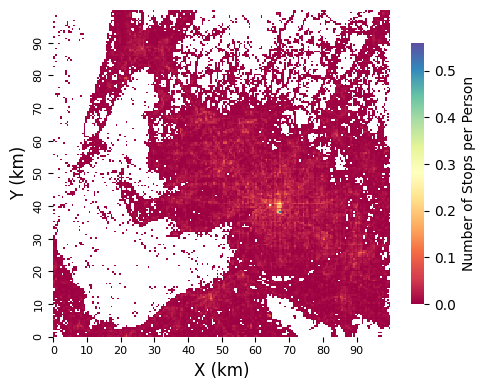

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_emerg.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 1]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the number of recordings for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and count the number of occurrences for each combination
user_recordings = df_returners.groupby(['uid', 'x', 'y']).size().reset_index(name='recordings')

# Step 3: Calculate the total number of recordings per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Normalize the recordings by dividing by the total number of returners
total_recordings_per_location = user_recordings.groupby(['x', 'y'])['recordings'].sum().reset_index()

# Normalize by dividing by the number of returners
total_recordings_per_location['recordings'] = total_recordings_per_location['recordings'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_recordings_per_location.pivot(index='y', columns='x', values='recordings')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Number of Stops per Person', 'shrink': 0.8, 'ticks': np.arange(0, 1.1, 0.1)},  # Adjust color bar ticks
    vmin=0,
    vmax=0.56,  # Automatically adjust the maximum value based on data
    xticklabels=20,  # Show tick labels every 20 intervals on x-axis
    yticklabels=20   # Show tick labels every 20 intervals on y-axis
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Number of Activity Stops per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


The following code generates the plot for average number of stops for explorers.

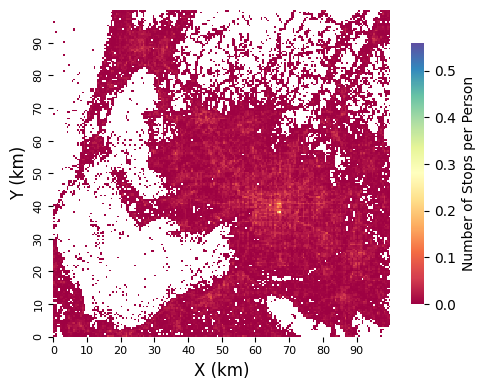

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_emerg.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 0]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the number of recordings for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and count the number of occurrences for each combination
user_recordings = df_returners.groupby(['uid', 'x', 'y']).size().reset_index(name='recordings')

# Step 3: Calculate the total number of recordings per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Normalize the recordings by dividing by the total number of returners
total_recordings_per_location = user_recordings.groupby(['x', 'y'])['recordings'].sum().reset_index()

# Normalize by dividing by the number of returners
total_recordings_per_location['recordings'] = total_recordings_per_location['recordings'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_recordings_per_location.pivot(index='y', columns='x', values='recordings')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Number of Stops per Person', 'shrink': 0.8, 'ticks': np.arange(0, 1.1, 0.1)},  # Adjust color bar ticks
    vmin=0,
    vmax=0.56,  # Automatically adjust the maximum value based on data
    xticklabels=20,  # Show tick labels every 20 intervals on x-axis
    yticklabels=20   # Show tick labels every 20 intervals on y-axis
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Number of Activity Stops per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


The following code generates the plot for average stay time for returners.

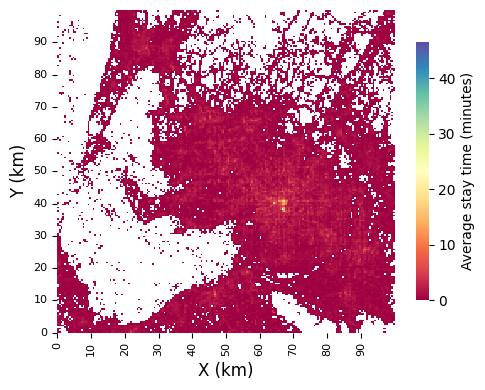

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_emerg.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 1]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the total time spent for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and sum the time spent at each location for each user
# Convert time_spent from hours to minutes
user_time_spent = df_returners.groupby(['uid', 'x', 'y'])['time_spent'].sum().reset_index(name='time_spent')
user_time_spent['time_spent'] = user_time_spent['time_spent'] * 60  # Convert to minutes

# Step 3: Calculate the total time spent per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Sum the time spent for each (x, y) and normalize by the number of returners
total_time_spent_per_location = user_time_spent.groupby(['x', 'y'])['time_spent'].sum().reset_index()

# Normalize by dividing by the number of returners
total_time_spent_per_location['time_spent'] = total_time_spent_per_location['time_spent'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_time_spent_per_location.pivot(index='y', columns='x', values='time_spent')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Average stay time (minutes)', 'shrink': 0.8, 'ticks': np.arange(0, 150, 10)},  # Shrink the color bar to make it thinner
    vmin=0,
    vmax=46.44,  # Automatically adjust the maximum value based on data
    xticklabels=10,
    yticklabels=10
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Time Spent per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()

plt.show()


The following code generates the plot for average stay time for explorers.

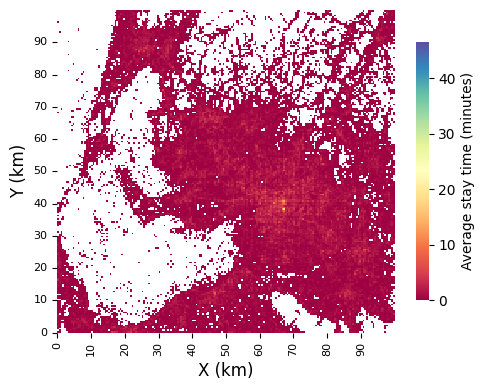

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two classification CSV files
df_classification_emerg = pd.read_csv('user_classification_emerg.csv')  # User classification data

# Step 1: Filter df_2_usual_explorerer based on returners from df_classification_emerg
# Select users that are returners (Returner == 1)
returners = df_classification_emerg[df_classification_emerg['Returner'] == 0]['UID']

# Filter the df_2_usual_explorerer dataset for these returners
df_returners = df_2_usual_explorerer[df_2_usual_explorerer['uid'].isin(returners)]

# Step 2: Calculate the total time spent for each (x, y) per person (per user)
# Group by 'uid', 'x', 'y' and sum the time spent at each location for each user
# Convert time_spent from hours to minutes
user_time_spent = df_returners.groupby(['uid', 'x', 'y'])['time_spent'].sum().reset_index(name='time_spent')
user_time_spent['time_spent'] = user_time_spent['time_spent'] * 60  # Convert to minutes

# Step 3: Calculate the total time spent per location (sum across users for each (x, y))
# Calculate the total number of unique returners
num_returners = df_returners['uid'].nunique()

# Sum the time spent for each (x, y) and normalize by the number of returners
total_time_spent_per_location = user_time_spent.groupby(['x', 'y'])['time_spent'].sum().reset_index()

# Normalize by dividing by the number of returners
total_time_spent_per_location['time_spent'] = total_time_spent_per_location['time_spent'] / num_returners

# Step 4: Create a grid for the heatmap
# Pivot the data to create a 2D grid (matrix) for the heatmap
heatmap_data = total_time_spent_per_location.pivot(index='y', columns='x', values='time_spent')

# Step 5: Create real-world tick labels in kilometers
x_km_labels = np.array(heatmap_data.columns) * 0.5  # Convert to kilometers
y_km_labels = np.array(heatmap_data.index) * 0.5  # Convert to kilometers

# Step 6: Plot the heatmap with thinner color bar
plt.figure(figsize=(5, 4))
sns.heatmap(
    heatmap_data,
    cmap="Spectral",
    cbar_kws={'label': 'Average stay time (minutes)', 'shrink': 0.8, 'ticks': np.arange(0, 150, 10)},  # Shrink the color bar to make it thinner
    vmin=0,
    vmax=46.44,  # Automatically adjust the maximum value based on data
    xticklabels=10,
    yticklabels=10
)

# Update axis ticks
ax = plt.gca()
ax.set_xticks(np.linspace(0, len(x_km_labels)-1, len(x_km_labels))[::20])  # Set x-axis ticks every 20 intervals
ax.set_xticklabels([f'{val:.0f}' for val in x_km_labels[::20]], fontsize=8)

ax.set_yticks(np.linspace(0, len(y_km_labels)-1, len(y_km_labels))[::20])  # Set y-axis ticks every 20 intervals
ax.set_yticklabels([f'{val:.0f}' for val in y_km_labels[::20]], fontsize=8)

# Axis labels and title
plt.xlabel('X (km)', fontsize=12)
plt.ylabel('Y (km)', fontsize=12)
#plt.title('Average Time Spent per Person for Returners', fontsize=14)

# Invert y-axis to start from 0 km at bottom
ax.invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


# 15 minute city

In [9]:

# --- Step 2: Classify users ---
def compute_rk(df, k):
    rk_dict = {}
    for uid, group in df.groupby('uid'):
        location_counts = group.groupby(['x', 'y'])['time_spent'].sum().reset_index()
        top_k = location_counts.sort_values('time_spent', ascending=False).head(k)
        t = top_k['time_spent'].values
        x = top_k['x'].values
        y = top_k['y'].values
        if t.sum() == 0:
            continue
        x_c = np.average(x, weights=t)
        y_c = np.average(y, weights=t)
        dist_sq = (x - x_c)**2 + (y - y_c)**2
        rk = np.sqrt(np.average(dist_sq, weights=t)) * 500
        rk_dict[uid] = rk
    return rk_dict

k = 4  # Top-k time-weighted locations
rk_dict = compute_rk(df_2_usual_explorerer, k)

# Assuming 'df_2_usual_results' has the radius of gyration values
rg_dict = df_2_usual_results.set_index('uid')['radius_of_gyration'].to_dict()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Use precomputed classification for k=6 ===
rk_dict_k6 = compute_rk(df_2_usual_explorerer, k=6)
classification_k6 = {}

for uid in rk_dict_k6:
    if uid in rg_dict and rg_dict[uid] > 0:
        sk = rk_dict_k6[uid] / rg_dict[uid]
        classification_k6[uid] = 'returner' if sk > 0.5 else 'explorer'

The following code generates the plot for holidays.

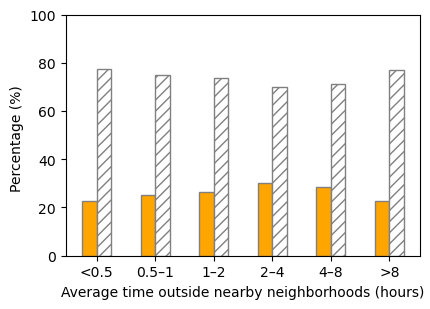

In [51]:


# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 1) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['time_spent'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 1].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 1, 2, 4, 8, 24]
labels = ['<0.5h', '0.5–1h', '1–2h', '2–4h', '4–8h', '>8h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

# Plot 'Explorers' bars with custom styling


plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average time outside nearby neighborhoods (hours)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
#plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot

plt.show()



The following code generates the plot for weekdays.

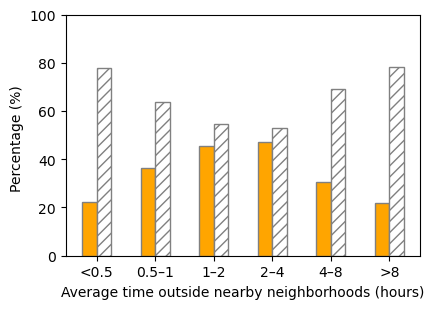

In [52]:
# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 0) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['time_spent'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 0].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 1, 2, 4, 8, 24]
labels = ['<0.5h', '0.5–1h', '1–2h', '2–4h', '4–8h', '>8h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

# Plot 'Explorers' bars with custom styling
plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average time outside nearby neighborhoods (hours)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
#plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


The following code generates the plot for weekdays.

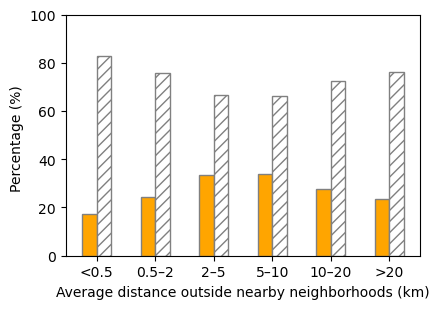

In [53]:
# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 0) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['dist'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 0].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 2, 5, 10, 20, 100]
labels = ['<0.5h', '0.5–2h', '2–5h', '5–10h', '10–20h', '>20h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average distance outside nearby neighborhoods (km)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
#plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


The following code generates the plot for holidays.

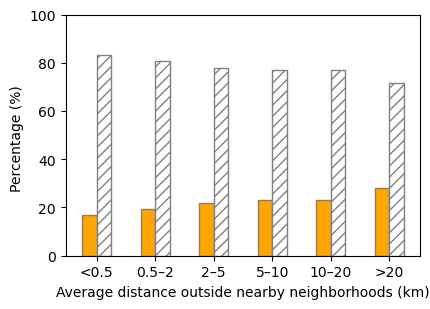

In [54]:
# === Step 2: Filter to holidays only and compute avg time outside nearby neighborhoods ===
df_holiday = df_2_usual_explorerer[
    (df_2_usual_explorerer['holiday'] == 1) & (df_2_usual_explorerer['walk_d_home'] == 0)
]

time_out_hol = df_holiday.groupby('uid')['dist'].sum()
unique_days_hol = df_2_usual_explorerer[df_2_usual_explorerer['holiday'] == 1].groupby('uid')['d'].nunique()
avg_out_time_hol = (time_out_hol / unique_days_hol).dropna()

# === Step 3: Merge with classification ===
classification_series = pd.Series(classification_k6)
classification_series.name = 'class'
merged_holiday = pd.concat([avg_out_time_hol, classification_series], axis=1).dropna()
merged_holiday.columns = ['avg_out_time_holiday', 'class']

# === Step 4: Bin users by holiday avg_out_time ===
bins = [0, 0.5, 2, 5, 10, 20, 100]
labels = ['<0.5h', '0.5–2h', '2–5h', '5–10h', '10–20h', '>20h']
merged_holiday['bin'] = pd.cut(merged_holiday['avg_out_time_holiday'], bins=bins, labels=labels, right=False)

# === Step 5: Count returners vs explorers in each bin ===
pivot_hol = merged_holiday.groupby(['bin', 'class']).size().unstack(fill_value=0)
pivot_hol_pct = pivot_hol.div(pivot_hol.sum(axis=1), axis=0) * 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the data processing and classification steps are already done
# Step 1: Use precomputed classification for k=6 and holiday time outside nearby neighborhoods
# These steps were already done before in your code

# Step 2: Generate the plot
plt.figure(figsize=(4.4, 3.2))

# Define the bar width
width = 0.25  # Narrower bars to display returners and explorers side by side

# Define the positions for the bars
x = np.arange(len(pivot_hol_pct))

plt.bar(x - width/2, pivot_hol_pct['explorer'], width, label='Explorers',
        color='orange', edgecolor='gray')

# Plot 'Returners' bars with custom styling
plt.bar(x + width/2, pivot_hol_pct['returner'], width, label='Returners',
        color='white', edgecolor='gray', hatch='///')

# Add the x-ticks for the bins
# Remove 'h' from tick labels
ticks = [str(label) for label in pivot_hol_pct.index]
ticks = [label.replace('h', '') for label in ticks]  # Remove 'h' from the labels
plt.xticks(x, ticks, fontsize=10)

# Axis labels and title
plt.xlabel('Average distance outside nearby neighborhoods (km)')
plt.ylabel('Percentage (%) ')

# Set y-axis limit to be from 0 to 100
plt.ylim(0, 100)

# Add legend
#plt.legend()

# Display gridlines on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


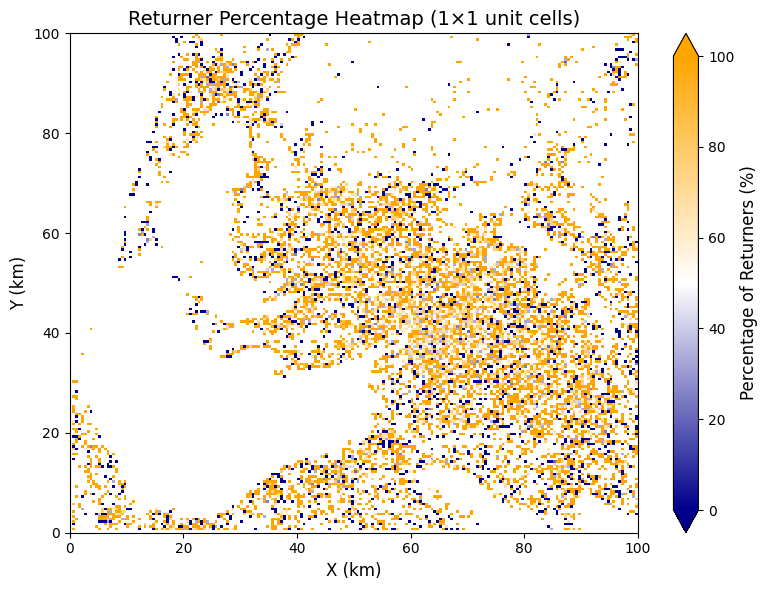

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create 200x200 grid (1 unit per cell)
grid_size = 200
x_bins = np.arange(0, 201)  # 0 to 200 (201 edges for 200 cells)
y_bins = np.arange(0, 201)

# Calculate histograms
returner_mask = spatial_df['class'] == 'returner'
returner_counts, _, _ = np.histogram2d(
    spatial_df.loc[returner_mask, 'x_h'],
    spatial_df.loc[returner_mask, 'y_h'],
    bins=[x_bins, y_bins]
)

total_counts, _, _ = np.histogram2d(
    spatial_df['x_h'],
    spatial_df['y_h'],
    bins=[x_bins, y_bins]
)

# Calculate percentage (set NaN where no data exists)
percentage_returners = np.full(returner_counts.shape, np.nan)  # Initialize with NaN
valid_mask = total_counts > 0
percentage_returners[valid_mask] = (returner_counts[valid_mask] / total_counts[valid_mask]) * 100

# Create colormap (blue -> white -> orange)
colors = ["darkblue", "white", "orange"]
cmap = LinearSegmentedColormap.from_list("custom", colors)
cmap.set_bad(color='white')  # NaN values will be white

# Plotting
plt.figure(figsize=(6, 4.5))

# Use pcolormesh with the exact grid
im = plt.pcolormesh(
    x_bins, y_bins, percentage_returners.T,
    cmap=cmap, vmin=0, vmax=100, shading='flat'
)

# Colorbar
cbar = plt.colorbar(im, shrink=0.7, fraction=0.046)  # smaller, thinner colorbar
cbar.set_label('Percentage of Returners (%)', fontsize=12)
cbar.outline.set_visible(False)  # remove black border

# Axis settings (show 0–100 km while data is 0–200 units)
plt.xlim(0, 200)
plt.ylim(0, 200)
tick_positions = [0, 40, 80, 120, 160, 200]
tick_labels = [0, 20, 40, 60, 80, 100]
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

plt.xlabel("X (km)", fontsize=12)
plt.ylabel("Y (km)", fontsize=12)

plt.tight_layout()
plt.show()
